In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import random
import numpy as np

sys.path.append("../src")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from real_data_desired_win_rate_reward import ProbabilityModel, BetaBernoulli, BiddingStrategy

In [6]:
df = pd.read_csv("../data/data.csv")
df

,sessionId,eventTimestamp,adNetworkId,bidPrice,hasWon,size,placementType
0,7328489402416276563,1621279594339,173,8.595383,1,480x320,rewarded
1,6011386765000368987,1621279528648,508,7.998000,1,320x480,rewarded
2,6367414109706735982,1621279599874,194,0.089800,1,320x50,banner
3,6603134055923190320,1621279553521,675,0.361505,1,320x50,banner
4,8572550066872572860,1621279562240,332,0.132451,1,728x90,banner
...,...,...,...,...,...,...,...
518735,7920770263731164916,1621256325973,731,1.701674,0,320x480,interstitial
518736,7920770263731164916,1621256325973,748,7.920000,0,320x480,interstitial
518737,7920770263731164916,1621256325973,750,8.080000,0,320x480,interstitial
518738,7920770263731164916,1621256325973,247,1.228270,0,320x480,interstitial


In [19]:
cls = BetaBernoulli(1, 1000)  # Defining an instance of this BetaBernoulli with 1 win, 1000 loses as our prior
df = pd.read_csv("../data/data.csv")
df = df.query("placementType == 'interstitial'")
max_data_point = 20  # max value of bins
n_bins=1000
desired_win_rate=0.5

(0.0, 20.0)

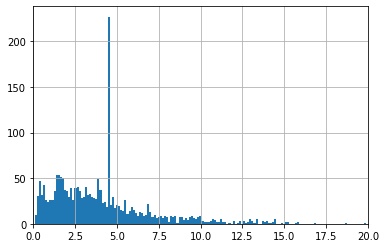

In [20]:
df.head(2000)['bidPrice'].hist(bins=1000)
plt.xlim(0, max_data_point)

In [21]:
format = "%m/%d/%Y, %H:%M:%S"
biddingStrategy = BiddingStrategy(n_bins=n_bins, max_bid=max_data_point, priors=[1]*n_bins, classifier=cls, desired_win_rate=desired_win_rate)
print ("Init done")
biddingStrategy.learn_priors(df, 1)
print ("Prior learnt")
print("Simulation Start:", datetime.now().strftime(format))
regret_arr, mean_regret = biddingStrategy.simulate_by_real_dataset(df.head(2000), 0.99)
print("Regret:", mean_regret)
# print(regret_arr)

Init done
Prior learnt
Simulation Start: 05/18/2021, 16:58:58
Regret: 6.323046764001476


In [ ]:
for p,m in biddingStrategy.bid_model.items():
    print ("{p:0.3f} {t:0.2f} {f:0.2f}".format(p=p,t=m.prior_T,f=m.prior_F))

In [ ]:
normalized_prbs_arr = list(biddingStrategy.parameters().values())
normalized_prbs_arr = biddingStrategy.normalize_probs(normalized_prbs_arr)
plt.bar(biddingStrategy.parameters().keys(),normalized_prbs_arr)

In [ ]:
X = regret_arr
w=15
X  =np.convolve(X, np.ones(w), 'valid') / w
plt.plot(X)
plt.ylim((0,1))
plt.title("regret over time")

In [ ]:
reward_arr = []
bids_arr = []
win_lose_arr = []
probs_arr = []
params_arr = []
regret = 0
n_trials = 100

T_arr, F_arr = [], []

for i in range(0, n_trials):
    # b = biddingStrategy.bid([i]) # [i] is context, not used for now
    b = random.random()
    print("bid is:", b)
    normalized_prbs_arr = list(biddingStrategy.parameters().values())
    normalized_prbs_arr = biddingStrategy.normalize_probs(normalized_prbs_arr)
    params_arr.append(normalized_prbs_arr)
    
    auction_bid = 0.4 + (random.random() - 0.5) * 2 * 0.1 # generating some bid for the auction
    print("auction bid is:", auction_bid)
    
    bids_arr.append(b)
    win = b > auction_bid
    win_lose_arr.append(win)
    regret += np.abs(b - auction_bid)
    
    biddingStrategy.discount(0.99)
    
    r = biddingStrategy.reward(bid_price=b, won=win, context=[i])
    probs_arr.append(biddingStrategy.probabilities)
    reward_arr.append(r)
    
    # plot
    plt.bar(biddingStrategy.bid_model.keys(),params_arr[i])
    plt.plot(biddingStrategy.bid_model.keys(), np.ones(n_bins)*desired_win_rate, c='red')
    plt.show()
    

print(regret / n_trials)

In [ ]:
# random - 0.4
# some_base_logic_base_on_notebook_graphs - 0.29
# our logic: 0.46-0.5

In [ ]:
# Moving parts:
# n samples - agg strategy
# discount rate
# prior - moving part
# normalize probs
